<a href="https://colab.research.google.com/github/shadikhan/758BColabs/blob/master/ShadBUDT758BNoTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
# Run only once
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
os.listdir('/content/drive/My Drive/chest_xray/train')

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [10]:
os.getcwd()

'/content'

In [0]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Changing the images to gray scale. 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [0]:
validation_data = get_data('/content/drive/My Drive/chest_xray/val')

In [18]:
len(validation_data)

16

In [0]:
train_data = get_data('/content/drive/My Drive/chest_xray/train')
test_data = get_data('/content/drive/My Drive/chest_xray/test')

In [25]:
len(train_data)

5226

In [27]:
len(test_data)

624

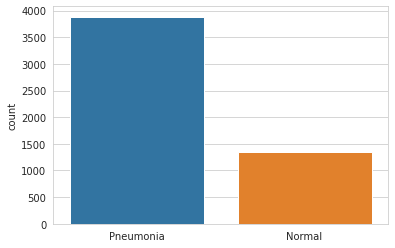

In [32]:
lst = []
for i in train_data:
    if(i[1] == 0):
        lst.append("Pneumonia")
    else:
        lst.append("Normal")
sns.set_style('whitegrid')
sns.countplot(lst); 

Need to increase the number of training samples since the data is imbalanced with more pneumonia cases.

In [0]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in validation_data:
    x_val.append(feature)
    y_val.append(label)

Grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].


In [0]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [0]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

Using DA for to avoid overfitting problem and make our existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. 

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [38]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)      

In [39]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
164/164 [==============================] - 222s 1s/step - loss: 0.5327 - accuracy: 0.7449 - val_loss: 0.6528 - val_accuracy: 0.8125
Epoch 2/10
164/164 [==============================] - 219s 1s/step - loss: 0.3881 - accuracy: 0.8215 - val_loss: 0.7229 - val_accuracy: 0.8125
Epoch 3/10
164/164 [==============================] - 219s 1s/step - loss: 0.3079 - accuracy: 0.8676 - val_loss: 1.7642 - val_accuracy: 0.6875
Epoch 4/10
164/164 [==============================] - 224s 1s/step - loss: 0.2552 - accuracy: 0.8932 - val_loss: 0.6595 - val_accuracy: 0.7500
Epoch 5/10
164/164 [==============================] - 220s 1s/step - loss: 0.2252 - accuracy: 0.9070 - val_loss: 1.4162 - val_accuracy: 0.7500
Epoch 6/10
164/164 [==============================] - 223s 1s/step - loss: 0.1970 - accuracy: 0.9275 - val_loss: 1.1434 - val_accuracy: 0.6250
Epoch 7/10
164/164 [==============================] - 219s 1s/step - loss: 0.1830 - accuracy: 0.9344 - val_loss: 1.1385 - val_accuracy: 0.6250

In [40]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 7s 11ms/step
Loss of the model is -  34.27818079407399 %
624/624 [==============================] - 7s 11ms/step
Accuracy of the model is -  90.38461446762085 %


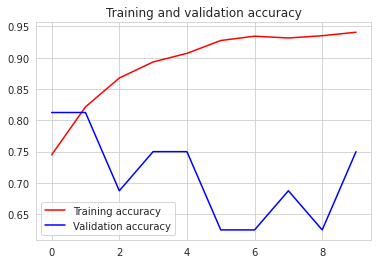

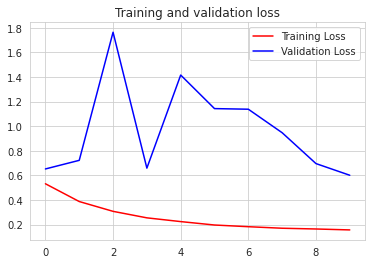

In [41]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

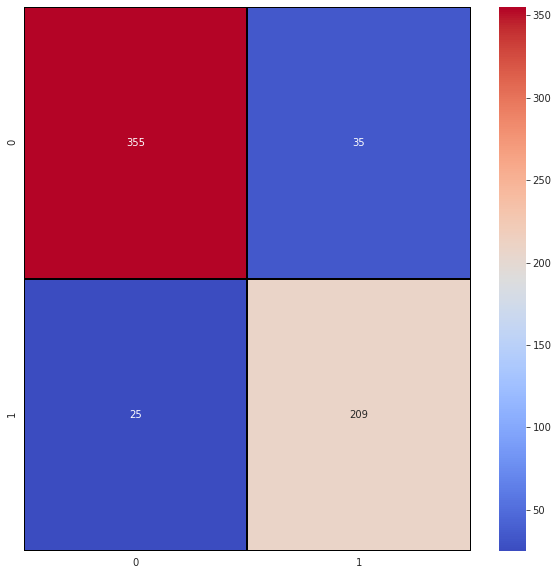

In [43]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

cm = pd.DataFrame(confusion_matrix(y_test,predictions), index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');

In [0]:
model.save_weights(filepath='/content/drive/My Drive/chest_xray/shad_final_weight.h5')